In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

image_count = 0  # Initialize a counter for the number of images
annotation_count = 0  # Initialize a counter for the number of annotation files

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Check if the file is an image
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            image_count += 1  # Increment the image counter
        # Check if the file is an annotation file
        elif filename.endswith('.xml'):
            annotation_count += 1  # Increment the annotation counter

print(f"Total number of images: {image_count}")
print(f"Total number of annotation files: {annotation_count}")

Total number of images: 2829
Total number of annotation files: 2829


Sample of Dataset Raw Images



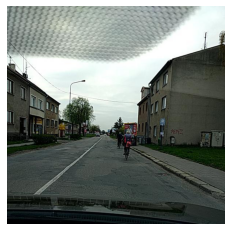

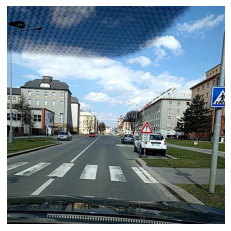

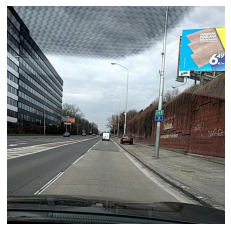

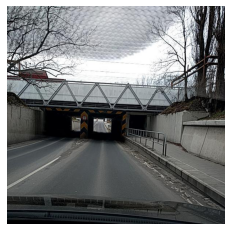

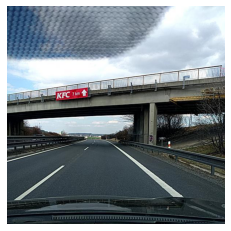

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import os
# import warnings
# warnings.filterwarnings("ignore")
print('Sample of Dataset Raw Images\n')
count = 0  # Counter for the number of images displayed
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if count >= 5:  # Check if 10 images have been displayed
            break
        image_path = os.path.join(dirname, filename)
        try:
            with Image.open(image_path) as img:
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                count += 1  # Increment the counter
        except Exception as e:
              pass  # Do nothing
            #print(f"Error displaying {image_path}: {e}")

In [ ]:
from xml.etree import ElementTree as et
import glob
boxes = []
labels = []

for xml in glob.glob('../input/road-damage-detection/Road_Damage_Detection/annotations/xmls/*.xml'):
    tree = et.parse(xml)
    root = tree.getroot()
    for member in root.findall('object'):
        # map the current object name to `classes` list to get...
        # ... the label index and append to `labels` list
#         print(member.find('name').text)
        labels.append(member.find('name').text)
        # xmin = left corner x-coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        # xmax = right corner x-coordinates
        xmax = int(member.find('bndbox').find('xmax').text)
        # ymin = left corner y-coordinates
        ymin = int(member.find('bndbox').find('ymin').text)
        # ymax = right corner y-coordinates
        ymax = int(member.find('bndbox').find('ymax').text)
        if(ymax<=ymin):
              print(f"Invalid bounding box: {xmin}, {xmax}, {ymin}, {ymax}")

In [5]:
import cv2
cv2.imread('../input/road-damage-detection/Road_Damage_Detection/images/Czech_000000.jpg').shape

(600, 600, 3)

In [6]:
print(np.unique(labels))

['D00' 'D10' 'D20' 'D40']


In [7]:
# configs
import torch

BATCH_SIZE = 8 # increase / decrease according to GPU memeory
RESIZE_TO = 768 # resize the image for training and transforms
NUM_EPOCHS = 50 # number of epochs to train 

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '../input/potholes-and-road-damage-with-annotations/potholes'
# validation images and XML files directory
# VALID_DIR = '../input/underwater-trash-detection/val'

# classes: 0 index is reserved for background
CLASSES = [
    'background','crack' ,'damage' ,'pothole' ,'pothole_water' ,'pothole_water_m'
]
NUM_CLASSES = 6

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = True

# location to save model and plots
!mkdir 'outputs'
OUT_DIR = './outputs'
SAVE_PLOTS_EPOCH = 1 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 1 # save model after these many epochs

mkdir: cannot create directory ‘outputs’: File exists


In [ ]:
#utils
import albumentations as A
import cv2
import numpy as np

from albumentations.pytorch import ToTensorV2

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            plt.imshow(sample)
            plt.title('Transformed Image')
            plt.show()

In [ ]:
%pip install mean_average_precisio
import numpy as np
!pip install mean_average_precision
from mean_average_precision import MetricBuilder
def get_batch_mAP(outputs,targets):
    # print list of available metrics
#     print(MetricBuilder.get_metrics_list())
    # create metric_fn
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=NUM_CLASSES)
    # add some samples to evaluation
    
    for b in range(len(outputs)):
        preds = []
        for i in range(len(outputs[b]['boxes'])):
            bboxes = outputs[b]['boxes'][i].tolist()
            label = outputs[b]['labels'][i].tolist()
            score = outputs[b]['scores'][i].tolist()
            pred = bboxes + [label,score]
            preds.append(pred)
        preds = np.array(preds)
        
        gts = []
        for i in range(len(targets[b]['boxes'])):
            bboxes = targets[b]['boxes'][i].tolist()
            label = targets[b]['labels'][i].tolist()
            crowd = targets[b]['iscrowd'][i].tolist()
            gt = bboxes + [label,0,crowd]
            gts.append(gt)
        gts = np.array(gts)
        
        metric_fn.add(preds, gts)
    # compute PASCAL VOC metric
#     print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")
    voc_pascal_map = metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    # compute PASCAL VOC metric at the all points
#     print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")
    voc_pascal_map_allpts = metric_fn.value(iou_thresholds=0.5)['mAP']

    # compute metric COCO metric
#     print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")
    coco_map = metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
    return voc_pascal_map,voc_pascal_map_allpts,coco_map    
        


ERROR: Could not find a version that satisfies the requirement mean_average_precisio (from versions: none)
ERROR: No matching distribution found for mean_average_precisio
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import cv2
import numpy as np
import os
import glob as glob

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models

# the dataset class
class PotholeDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_path.replace('jpg','xml')
        annot_file_path = annot_filename
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [ ]:
# prepare the final datasets and data loaders
train_data = PotholeDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
# valid_dataset = TrashDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
valid_size=0.2
train_size=1-valid_size
num_train=len(train_data)
split=int(np.floor(valid_size*num_train))
train_dataset, val_dataset = random_split(train_data, (num_train-split,split))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}\n")

In [ ]:
dataset = PotholeDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES)
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    box = target['boxes'][0]
    label = CLASSES[target['labels'][0]]
    cv2.rectangle(
        image, 
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0), 2
    )
    cv2.putText(
        image, label, (int(box[0]), int(box[1]-5)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
    plt.imshow(image)
    plt.title('Image')
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
#     print(target)
    visualize_sample(image, target)

In [ ]:
# model
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')
model.train()
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        desc= ""
        for key,value in loss_dict.items():
            desc+=f"{key}: {value:.4f} "
        losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=desc+f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
#             print(targets)
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [ ]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    from utils import show_tranformed_image
    show_tranformed_image(train_loader)

In [ ]:
# My Trainig Model
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# Define the LossTracker class
class LossTracker:
    def __init__(self):
        self.values = []
        self.sum = 0
        self.count = 0

    def reset(self):
        self.values = []
        self.sum = 0
        self.count = 0

    def update(self, value, count=1):
        self.values.append(value)
        self.sum += value * count
        self.count += count

    @property
    def avg(self):
        return self.sum / self.count if self.count > 0 else 0

# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the model
model = MyModel().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the data loaders
train_loader = ...  # Replace with your train data loader
valid_loader = ...  # Replace with your validation data loader

# Set the number of epochs and other configuration parameters
NUM_EPOCHS = 10
SAVE_MODEL_EPOCH = 5
SAVE_PLOTS_EPOCH = 5
OUT_DIR = "output"

# Create instances of LossTracker for training and validation
train_loss_hist = LossTracker()
val_loss_hist = LossTracker()

# Start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # Reset the loss trackers for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    # Create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    
    # Set the model to training mode
    model.train()
    
    # Start timer and carry out training and validation
    start = time.time()
    
    # Training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to device
        data, target = data.to(device), target.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Record training loss
        train_loss_hist.update(loss.item(), data.size(0))
    
    # Set the model to evaluation mode
    model.eval()
    
    # Validation loop
    with torch.no_grad():
        for data, target in valid_loader:
            # Move data and target to device
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Record validation loss
            val_loss_hist.update(loss.item(), data.size(0))
    
    print(f"Epoch #{epoch} train loss: {train_loss_hist.avg:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.avg:.3f}")
    
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    
    if (epoch+1) % SAVE_MODEL_EPOCH == 0:  # Save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')
    
    if (epoch+1) % SAVE_PLOTS_EPOCH == 0:  # Save loss plots after n epochs
        train_ax.plot(train_loss_hist.values, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.values, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')
    
    if (epoch+1) == NUM_EPOCHS:  # Save loss plots and model once at the end
        train_ax.plot(train_loss_hist.values, color='blue')
        train_ax.set_xlabel('iterations') 
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.values, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        plt.close('all')
    
    # Sleep for 5 seconds after each epoch
    time.sleep(5)


In [ ]:
# start the training epochs 
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')
    # sleep for 5 seconds after each epoch
    time.sleep(5)

In [ ]:
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    
    # set the model to training mode
    model.train()
    
    # start timer and carry out training and validation
    start = time.time()
    
    # training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        # move data and target to device
        data, target = data.to(device), target.to(device)
        
        # clear the gradients
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # calculate loss
        loss = criterion(output, target)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # record training loss
        train_loss_hist.update(loss.item(), data.size(0))
    
    # set the model to evaluation mode
    model.eval()
    
    # validation loop
    with torch.no_grad():
        for data, target in valid_loader:
            # move data and target to device
            data, target = data.to(device), target.to(device)
            
            # forward pass
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # record validation loss
            val_loss_hist.update(loss.item(), data.size(0))
    
    print(f"Epoch #{epoch} train loss: {train_loss_hist.avg:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.avg:.3f}")
    
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    
    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')
    
    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss_hist.values, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.values, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')
    
    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss_hist.values, color='blue')
        train_ax.set_xlabel('iterations') 
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.values, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        plt.close('all')
    
    # sleep for 5 seconds after each epoch  
    time.sleep(5)

In [ ]:
import matplotlib.pyplot as plt
import time
import torch

class LossHistory:
    def __init__(self):
        self.history = []

    def reset(self):
        self.history = []

    def append(self, value):
        self.history.append(value)

# Define constants
NUM_EPOCHS = 50
SAVE_MODEL_EPOCH = 5
SAVE_PLOTS_EPOCH = 5
OUT_DIR = "path_to_save_models_and_plots"

# Initialize loss histories
train_loss_hist = LossHistory()
val_loss_hist = LossHistory()

# Start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # Create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # Start timer and carry out training and validation
    start = time.time()
    # Assuming train and validate functions are defined elsewhere
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    print(f"Epoch #{epoch} train loss: {train_loss:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # Save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # Save loss plots after n epochs
        train_ax.plot(train_loss_hist.history, color='blue')
        train_ax.set_xlabel('epochs')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.history, color='red')
        valid_ax.set_xlabel('epochs')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # Save loss plots and model once at the end
        train_ax.plot(train_loss_hist.history, color='blue')
        train_ax.set_xlabel('epochs')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.history, color='red')
        valid_ax.set_xlabel('epochs')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')
    # Sleep for 5 seconds after each epoch
    time.sleep(5)


In [ ]:
# start the training epochs With ReduceLROnPlateau

from torch.optim.lr_scheduler import ReduceLROnPlateau
import logging
import torch.optim as optim

# Define your model and other necessary components here

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Initialize learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Start the training epochs
for epoch in range(NUM_EPOCHS):
    logger.info(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    logger.info(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    logger.info(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    logger.info(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{OUT_DIR}/best_model.pth")
        logger.info('SAVING BEST MODEL...')

    # Save loss plots and model
    if (epoch+1) % SAVE_PLOTS_EPOCH == 0 or (epoch+1) == NUM_EPOCHS:
        save_plots_and_model(model, train_loss, val_loss, epoch+1)

    # sleep for 5 seconds after each epoch
    time.sleep(5)


In [ ]:
import matplotlib.pyplot as plt
import time
import torch

class LossHistory:
    def __init__(self):
        self.history = []

    def reset(self):
        self.history = []

    def append(self, value):
        self.history.append(value)

# Define constants
NUM_EPOCHS = 50
SAVE_MODEL_EPOCH = 5
SAVE_PLOTS_EPOCH = 5
OUT_DIR = "path_to_save_models_and_plots"

# Initialize loss histories
train_loss_hist = LossHistory()
val_loss_hist = LossHistory()

# Start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # Create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # Start timer and carry out training and validation
    start = time.time()
    # Assuming train and validate functions are defined elsewhere
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    print(f"Epoch #{epoch} train loss: {train_loss:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # Save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # Save loss plots after n epochs
        train_ax.plot(train_loss_hist.history, color='blue')
        train_ax.set_xlabel('epochs')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.history, color='red')
        valid_ax.set_xlabel('epochs')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # Save loss plots and model once at the end
        train_ax.plot(train_loss_hist.history, color='blue')
        train_ax.set_xlabel('epochs')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss_hist.history, color='red')
        valid_ax.set_xlabel('epochs')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')
    # Sleep for 5 seconds after each epoch
    time.sleep(5)


In [ ]:
# !wget -O image1.jpg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcqd8t2wKlKSDUPYGSTQl83fNpccs4S5NrHA&usqp=CAU'
# !wget -O image2.jpg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ8A9xjh41z99pzjUHylStskyvDWzgaPiYvzw&usqp=CAU'
# !wget -O image3.jpg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQUlGd8atGfUHXiFoVMNI-l7CRkQeNczD-78w&usqp=CAU'
# !wget -O image4.jpg 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYZGBgaHB4eGhwcHCEeHBoaHh0cHBwhHh4cJS4lHB4rIR8cJjgmKy8xNTU1HCQ7QDs0Py40NTEBDAwMEA8QGhISGjQhISE0NDQ0NDQxNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDE0NDQxNDQxNDQ0ND80NDQ0NDE0P//AABEIALgBEgMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAACBQEGB//EADsQAAECBAQDBgUCBQQDAQAAAAECEQADITEEEkFRYXGBBSKRobHwEzLB0eFC8QYUI3KSFTNSYkNTgsL/xAAXAQEBAQEAAAAAAAAAAAAAAAAAAQID/8QAHhEBAQEBAAMBAAMAAAAAAAAAAAERAhIhMXFBUWH/2gAMAwEAAhEDEQA/APkIiGJHFWiDrRcigPTw/cRSDSq93eo5i3jUc2gIFODvQ/SIs7xUUPkYj78oCv5iwFekVMW16QEF4slXvwioNYjawElqgqgK+9YAm45QYWdxxEBxJiq1RdKYqoRRXaLpEVAiwpEFFpP5iyBFkqblrFQK8IoLKkk6dYZkqCXH1gUuZo8WTLF3hpgk00vygS10gjecdTglKYJBUTVgHPlCUwKXMrDK50Wldjzn/wBtXWnrBMT2ZMQnMtOUWFftGsqFlq4wLNFlJ0jhQ0TVxDtxisyO5oGZmzGJoFNNDHAYi7c4qIghioiPHCqAmsVVHQY4BFHrMAP6Uv8AsT6CJFsB/tS/7E+giQHkSYkRUdTEEiPHSmkRIgLrL11148Y5meKgxwQHYhV6R1o5q8BYCOE0iyhFVJgImCpTxgaRWLlWsBx4sBFSIuUGA6gQco7pVpbrSAIRGjhsOpSSk0DODxiVrWYsF4smUo6RuyuzgoMlzZtBxrt9o0cP2UgUJ6Anz/aNTm1m15nD4JaiAAfDjG5gP4Xmq+ZkjRzXwEb8kJlpslCd9+XGNORPWWKLbhBUTHScz+WPKkML/DEhDFZUs/8AEkJSPEOekej7MwqEJZCJaHOmvMmpMDwRy/OsJJuGIJ5AxqoU9pjDQUPrG5JE0FMtYJcobgk201jK7cQ0tZWEq/4sNrXcR6FSDcn6P4QnipWdJBaA+N45GRbXfUWB/aEpi6x7rtHs9KCrMHegIbzLEiPL4/s0JUVDMA7MRXd3ZmtHLrnG+brKUmldooQ0NTAA4hVcYbcEVizRIIo0VJi0daAHljqQI6oRyCPXYA/0pf8AYn0ESK4D/al/2J9BHYo8jFhR99Pfu8dKTo8QViCgEXSgm1eUdCHMHlJUHyg8dfW8AFtLQNQa/jDwlKNCW4MB6Q3g0FBzIWUkNUFrWgMdP7cYImUTVi27RtzgVqzLWVq3UpyOA2EVGFFed7wxGR8BWg+8RWHXsXjaTKbc+Qg8vD8L8zF8aa8+nCrOjc6QeRg928R7Ebpk6N5fVoOMG7MNak++ULBlfycv9IXpdvoLQVGG0CSR0brGqJYTQgHr9B94qpIHPYD35xZzoVk4VIskc/fGGkScunn97CkHkyxv0uRF1oaoST0frSNTIOyhowGzEGDhCUkWDt+qp33MIqxCbZVAnZgYelBJulQ5gcNeMaZO4WScwdind1P4BgI1sHhUpchNaklrvxIfxjFRnYlBSrYZ29E0HCFl9srSQkoKD1Pg7O1aRZUyvSzXUSnO2WpTmAAGyswIJ4NFJGBKwCmajJfKCQepRl9IzpCJM2vxlqJDkfAHqTw3hj+WnIUBLyLd3/poQobmqzmMUehKUhIAOmhJ9THEqozEaRlIwMw95S2NGCEoS443HlFJGEnIVRYY3BDkD/5OUl3gina+EJB7wrwjys8LSakEAUd+8NnJYFvZj3CkEpIUK+H3aPP9p4UgtlppXyMLNWPF9oysyszhvFuUZM4CwePS4tBSQUoC2sCHsKWOlecZM3KQXyg6kAgatU3LRx659tystojcIYVhzVreZ9vAMht9Iy0obxwiCfDJsH0/aCfyqmdvL7RNXAAk7RAgPeH8MnKzjWnEWL8Hp1MDxZq5v48PsOkN9mPQYAf0pf8AYn0ESC4KUPhov8qfQRIpjzqZlBXmL0+kcCHNh6N9xAkG78eFIIs15HbTlyjKVdCRrTygqZYctTWsBRM61J4/j8Q1hwDVjbYt9jBmqoQnQv741gqFAGg99IIkvUUpWw+t46irUd+DVbnGoL52Gn36GsWDlg3g9L6EcvGGJeFBFQwGnlrpDacMB8ujVJp74CNWkJjCk3DDrWGZeFSzJ5cOkFOHJqp2469NG+nWIFpFEgczGfdX1EThEgOanyflEUuzUEcBG45+nvjBv5Yk08gHjc5/tnSzV+5vrDUiQWdgOIavgYquSpNkqPHKD0hNeKynLlUCdwBeLf8AD9MryJJ7rn3rBkKLOxHBz9IVRik2Y8ibwxhwVhxlZ9VE+QFIvqfT8W+CsnRvW3VoPLUp2KARqQA+tAFUHOBYgLTUZKVarnlHE4qhUUEUpd3iyy/EsrUw02Qg5l/ESprBSwz7BB4baRfFyUTCMuFxE4CrrmrSxpQZ1HTlGPhMRJVWfNmJNfkFPIE7Q7P7UShH9HFYhZeykpYDV1LSDbSACrsPEpKlolTEAv3UqBIB0dJc+EanZHazKyLC0HUKBSSRR6i8ZmH7fxK1pQMSZbqbOtKMqQxqSlDh7fWN7DdgKmkGbjxMX+koIJAZ6OqnQCLKVrLY2W7ixuKRmz8YUKCVWNiCL8mBs8NTP4RLEHEzqv8ANUcr2EYPavYa5Cc4xKVsD3VMlTbBycz8WEa1MbSJwUlwo/XzhXFSgpN38/zHlpXasxFc6SnbMCdbsfSkb4xAyhSgQdQFOObE24xNGVjcMxJI51+8ZGNSh3SA5ulSaWvWgOvjG/ipiFjuqqR3X1fSMGdLrTqKsff1idLGXOloJ7qQTY0AbU8/2gE3DNWoDaA0913jRnoQtBDHO4YMLu9zXy0HTK76KpSO84q55gB6HlHDqWNxEIKSWLbnQcYqssAUvQVetzV34wtMmrzd6/t7QCYouRX8xnK35HVT0qLlwrQgBvDxiTpZLkNXTUC4veFpUs1elL7RoSkZndIIGpd61LNo51h8N16HAZhKlhzRCf08BHYYwg7iO8flHoOMSGmPAJVQ0PveO5zBpCXfu05vveOqkjk9hGmNEwyyAf03qeMMoWaPXfKPLhEwfZ6lEaJuXsfz943MNhUIDqAJ3PQUEAjIwhUGPi56Rq4SQEsAHbc1tptBkJJL1AtzEXQyQ5DAe9YmmLplgj7e+MUWsJpUnqSbbwCdilKonu/9hQ9HtpA5IagBO9fPf9o1Od+pquJmLWkN3U7XJLPU7U04xEYQlnIHV/OGcovR+UDKCqrqbQBh76xuTEriezlUKAW3frEVj5qCEkJruC/O9orNxUxKaLNPdTfwhArJJzEnpfx46Qvv6jYl4ifMsw4kc7O9Iqex11JWNyWc6m7tA8HgpuUKfKNz9B94dGHmD/y6aJFIzbjU9kV4FaTmzApt0YcKRxMt1Duj1aO4jCkHvTM39xtW4Hu0Ww6gRsa1Bpo1o1zdZvppSZAJyg1ZzZLg++Nusasjs1GqSX3USI8+MKk3S53r9KwuMJN7xzqTWwUoDhbS0WyrMezR2bhpacypctKdVKAau5V08oz8X2rg0qypkImMHKkhASCXDOdaC28ec/0pYBeZ0uz0u+oe28c7MKZM8LWnOkHvJYFxwelCx6M8XLDRMd2ilZzS5CJSU/8AEEqJfU0HFmgAnYlQBRKmLFK5FFLaUZiOcfTcB21h1IzIVkTspJQwHRmhsdsYZv8Afl/5j7wR8uVipzBczDrozky1AHkCMu0OI7ZRkBKEkiyWIc8iGFo+hr7cw4/86DyU56ZXMYvaXbWFWCPh/FoQ+RhTQKUx8Io8gO15JZQl5VDSgF3fMAXMPSv4iQthVPXxsR7ePO4mXlJUlRIU/cqyeALOTbpwtML2ctSVKe1e8kl+RcP4xNo9RNxKL5QpJYvoNuW7xl9pFBqkAH9QhbD4RZSquUioyu+t9THP5NTVqLEg3EUJYgBVQWI0B+phMgEEMMxL5i9msK8edm4sTZYQau1a6Vvr7aFVy9vI0qHZrxirCq5YtRvDwiq8gNfEPR94KpKQDVzobwsMOCwIOmvTQ06xy6jcOo+GgJIBJJIbjQg/2kGOGeH7qCwFgk7NvYCKSg6cpOQDgSSNgRUa+MLz8R3SE0tW5YPsSwqPCMY3r1OHmd1NrDThyiQpgpv9NH9qfQRI14s6xZEnMe5U+XjGtI7NTQqrV9W92hmUhIoBDCERdTFJcrQO0MoQBxO8L4jEJSKk8gzwlNxC1WoPdzCc2prQm4vLbvaM9BC65pWa+FmZtN+MKpRa3nDEtLeyY6SSM22ipQL6cvZhgU1+0DC2qf35RZTG47vG/wC/nFR0kanz4sXg2QNtyMSXg8qDMUWGhJqW4+MB+M7nTyiis8ZU/K76C3XeBS5BIs3L9oOJwbfZra+P7wZJo4gOISoBs6vG78DaKkk3Wo0b5md44AST9OMXNqCrbN+0MgVmhANQlxqbk84tKmJAoXNjlb72jMx6ySxHKttWheWhmJa7X9tE1cbYm5alVGcAqevHXaIMVMNQT/1apVq9BWFsPg1TKFtqFw2uopfe9o9d2RhEJHdT1d6caneF6xJNecwqMUskplrUNwl2tYsPxF1YbGIVmEqZXQpcaXCY9/h/fKG0JJ2iyrj5viO3JsvuqlAECoWKHmDYcIYk/wAQIWpIICTR6BiXoK8D4R9CxUhExOSYkLTsbR5T+Jf4flol55CShVWypzB6C6qpOobYxdqYRndqIy0IUDYl2fWijUPy6RdHa0hKQQUFeuVLG1NXAfWseOmrrRIBufwBx/MDQCVBPFtBybrpDTHrJfbJWogIQa0UbPQCwvSGcKT3nQBVjx639bdI8/Lwq0MpYKMtXADkMzpIBDg5Tb7wUFRKjRno7VT+lhYV47ltYumN2XLAfLlTUkB/Ilr0gCjfOC/l5QsqUVAFBdTu+ZmIcedmq0KzkLzE94t8wu12YFhVjWLo7jsMS7Wq2rcnjExEkhw3VvGNj4iiSC7/AFsGen7QHFIcF/fHnGb7WMBb0cVb3ygU1T0enDRrU1h+fKFXHEEUP7/aALRcOXNwR7eOdjUrOnS1KZnL8CPF6PA/5ZbA5VAG5Zk9DakaKpqgGzOKd1hXZ3G+/SESojuGguNGc8Sw584zJVtevwOFHwpffR8id9hEgWCR/TR3x8qdeA4xIqCZwkQqrG3Cff2hNcwm5/ERJDcHhOcLRFOS5LniYKgAQFK9oKkvXyjSCJU9bDp7MMggQul4sVEBiA/M++kIyImYaUYU5+/vDsuQpsxcbOPMab1hnsTAqKgVBIG3kLRb+IQlJCUqJLVG3AEekaGZNmqcZlOdSffpEVihkqR74msLy5BHzGp2/Lw1gezFKIUo02JbbTzgLYdOYZiONft0hkKNnArxPlpF5igKUpZqxQSxqPAQEVe/Nvbn8QNdfz7oYIW8IjAcIBb4QBBavJuPOIvDhVix147+2gsyahIYqjq5lBkY/iKEJklaCFIBB3A4hxQ7i3CG8B2liEqAJDM3eSKXDnd4MhBPzl+Qb6w/JQDodfx74Q8TTQ7bngpBkoylu9nLeL0fT6vFj2xigpeRCEgqCu8VLYADMkEkO96CjxCa0px426QCUqtdzUgi3TURcTafT29iVjuolpfUhVmrQtWF53x1gqXNo4LBgNBZNzTWrtDuFAv9eVdz+YZCQUnutU3Z6G9D7pFweexvZy1IKihJUQMxKXN/+xfW7xlI7NAYrQphqCcrA1s7Cm0eun5iAC2UnVOgYioLCo2jqlJDAdGJ4GoffXjDB5WcCgFKpZo9FJBFzly5KGxPPZ4zUFSQFBCmdkhjlYuGCgxdtDXyj2U9aTQvU2LgD/GtvYjPxAly01UgIBBObu62d2NfrQxMVn4GaVOSkh6pD6b10tet6XghmS1koObW5cW2VramjR2dhVryLzlKQ5ypIIWD8pcch9g0EmyEswAClF7EjNSrk9HJhABeFQVB1hKWOb5r6E1sK6aQPFoCXynNuS41bfrB8VhVoS6mD7GratXnGLMxK8zA05F/fGJbhFMTLUeXXX86GM9adwG4CHhiX+YPpS0JziH867dTGK0EUfikLzMMLuH6OfvDBqKW8h7G+0cCTqOhgNzBSR8NFT8qdBsOMSGsI2RFP0jTgI5EVggBrRcIBav5joTThF0pio4iWOvpBQoDifvHAkfiOhQdh75wBNgG4fvB5Uprly/n7EBlmlCI0MClJLP3tHNPDXTwiyMjLx2RyakgsNrCp0vtGcggjMXPAWHBvesO4nBoFSuotQU2AEJqQQQ4CRoBqIoLhZKlOohgLOIcCAxd30+sWwzBLl2rEKzxf6e9YCiZYBtBkEbQIrHsxxKvetvdoC/xd0j3w1gKjAlTOfgW9+9ouhZO/kH6awFShOogySkHhtxioL3iyAPKAIFv+kHh7EGRMUaANToPME6WgSKU01PDWGhikhiwBOlPekaB1qUIrJlBasxSM2nJyRA5mMGrfevnrFDjgDahG9at0io10AOA9QN22f3xgne2Ljc0PEM7Cp40hHDdopWC4cVBDGoatDf30b/mApORyX6UettIC3x0ktmsHL6DfgLxRE9NwtJLsCLN0giF3LAvf/8AJIc0pfygsoobKE5WAtYawUFEzNRaa8tH89PKG5eElKSCUhWoevKE50sEAJ7tKOCBQ7ONorLnLCmAA5Ed4s9WFBxcmCDTOz5AB7gFw4DAmpslg43Pi8Zk6TLZSUqLmgZNr0NCANK/eGMd2iyDmDMpmuTVt2Dk01bnGGZic7gM96U6vWrt0hVdxWHWo95ZLCqRQONf2eMqfg8pJOur1PWNszyzBn8KMCH0HOsI4miSSOoFDdi+7bfvLNIxJwr3QDaATEqSWLjg9OdLmH8TKY6Pz47+6wkqYTXLx9iOeNF1KIqK2NfrAhOU9QG4fc+6QeYlLHSrG/u0AKhVmL/mw06wHqcIvuIr+kacBEgeDV/TRX9KfQR2IrJK3NhyFhHX8ekUpy6xVM0G2nmOmsEMDYabbQRGEUoOkWHTmXttpaGMFhSo5g2TieGlKvGzLQBb8wtwk1lI7LW1CLdOdorMSUEBy+40/MPY7GhAYHvaatxjFSCTxNfGLLUsNom0dn2vBEI/UqgHvnsIunCpSHKnU1gaae+sWCxbUB6U89YqDzHSAzkXoWanLvaUjgBBvwpbwP02imfpXfS2kVWtuHHf3SAXxM+pFnvX3W1t4aSoFIcdBq/05QliNkl9S1vz58Y5IxxRRbNZwCa/XnwMUaEmWA3kDp7pf8RaaWoPfOK/Eo703/cwCbOoT01fkICk5bDMFEUtw5X1HKFv5txcjQV0PDWwreKTlpUc2YFwaEMGD0A1Jc3paM3EAHS1g1OpHXwiWtNFHaxqC1mBZy+/AVHjAFdqvWoIIbxqIzJso7UIfg1umm142uyP4cmz0Zx3U0+YFI1LpDnMLaBiaRNqYB/qhpbifq2kETj3JUxYBwS3Sm/3jfmfweko+cgg1ZGYtZqkEgFi+wNIzMd/CU1CcyCF2oE10uC4Ie+3KzaYH/rBQRl52arAMW5DwhvDdvqVcBrhmv8AeMxP8N4lVfhmtehBf60pFk9mrQ4IIIJejfWh4HfwstMjePbACC6XSP3fe9ftC/8Ar6wFELVulwGcNQlnYtvY9IxDO/Sku7g1Zje5tR6atF0KRXvB2Lhi1ALcPtqYvlTHqD2qkjP+lQ0JYKuVEOKvoBTfSKYeelSSUqKVAAd49WBFqNevnHk0OzgGjggna50r+YcKFqYulDaOA2hsb8f+zRdMb6u1ElJRlJUKX4gWss633trmhFClJFCbMAFC4ueOukZiCpJZyg1ACqEly31tFUhYc94hy5Cqimrnv10+sS0xrfFKcuYsksCW5Djq0dmoTdhuSz0oVVF/2hWWrNVII0Llz+DavAQQJFdlO77txvTSCksX3Tbk5obVdvforNmKqFUINQzHq9X4cYfnBRAcPWp1HLfSMuaoBLPbVnd6AOeDnpEo4pXC24FYotbgsXNiLk/a0XzlQuWFgaUNT7eKlDFx7vq1Yg9BhF9xH9o9BHIvgkD4aO7+lOvARIisAIKnfj6N1gkpDVPp7aDLXXh7H0gXxg/vxio0sNjCilGNQ94tN7VXYMnlXwNox1zztXiNfrRotKTmNj6CGAvxFKO9b771h2Rh2Dk14bwOQgJ56wcF6++ZijqSfD0gqpmm7W1rZ/tvA8r6Gh8QfpXyiJD3tsCfGkTQUMC7B6en5iTDm+4+jViqlG1Nn9+7wTLQmpY1Ogc67bbWigCJbEsr0Fza0CTNAuQK2JY9M1ekFSsuXZmEEQkHgkBhWrnyf7wCgxFWObKKE6E3ua7QsrHCqSCQKAZg99W5+Q1hvGywaX4Pe3k7RjTZBArRq94gWaiX1q/R9IlDPxk16UFzWvA0r7aCzSCWIHAECuotxMZ6GcUq9xrya37w3MQQigrlZxpUfKX5B+bRRv8AYHZoUvOpGcBDpcpKM2YuAGdOjuKM0eylAC0eS/hKWzZmK6t3e8U1ZRUqrV0Y1MemQnKVFzVqaBg1NolIZHIesWRSlYohUdMFFzQricGiY7jvWcH2II8dMxr2Hl4xUeUxPZCSMpBoq77Vep/aMVfZykLylRYjjbNVlN3T11tHoziwslu8xJSXdhYVbn7tm4hCye8c12o1zuwNHbY0i5GWQsZSQHTXU95T7OK01HlAsSohNO8DwvQCo0INq+Mak1AyJKVlKjslQUkBQBcEVetdIDNlpUghk1+VyKj/ALceOnrGmfh1synYm+YgCrUBdwTX8waetSgye6AHZ3PAF6k0OovCk3CrSqoIsSRUHkdhxisucUmhAv033y871pANYLEJD30DuLi1rX1t6PCeCA7JfiKjg5e0IKWs/PlazkWaobUl23tDEtsjtcl6ksQWFHOwDQgGpblkudC1OVYFPllKqjR6kMauGbXnB/jKzAZVZdSCDp4g1ii0u9N7e9tbwCBQCXAYPt4avFiq1He+tqRdaMtfGjlufj4QNRba9HfV94g9JhEnIi3yjXgIkXwg7iL/ACjXgOESIPPrFG9+2gCZROnusFXMdtm0gklVaBo0LSMGW+Xxg6EsajaLnEUsIoVam+m0PQJle7jiIuhDUduPpFU1rcx3NVvPSILpUXOvPx0tc0jqlakin28ogoG04U4elIqRx8PSAKFPrHHzNq+w2LawILb3XztBgPTy9/WKOAMaNax98qwQFRFWA/EcQkWv9ftFVofg+3g/vaA6l1G1BqOo9IFOlEkEBJqXJd7EBg96wzLlACvva1TEWhqC5issZeHGcFlDZjcM1/XpBjlvTRgaGmhBhtcrU2o48Wpt9ITTKAoGBNWAYb2uHNYjSIllgUEjvBmpUUBBS5FrcWh1Ha2JYgLJAvvawzcGrCstBzFi6bVAYlql8raMXs8MImZUsB3ttaAaaCjPVmgGcB2wUKJdZKmcLUSSbXL5d7bRsf6+KjIp6MQzEa3N296RhSpCdE3Gru5N6j6a9IFPwpSWD1PMWI/V75wTXol/xCjKe6czaGnBiBtppaMvH9smZ8iQl2zAG7bqA02tGSqWcwuB/iOe+pFKF4PnCCMtmozsRSmz0Agpxa1mo7jgEmjjh403gCwpJUolahZh/wAnH6TzbbjSCS1lfzOGuAD9Kw2uUopSyQdQ5JDXtZzGmSisLppc62L6WD7/ALBm1LJKdSnLcU8TWNFaKOoEkbUI5Nz9YXINwLafq8fekMGNOXMSq9Lv1ZtOEKzEm4LMCaMx5VNOI+kbU5RyqACnCXenIbEm8LEoUAFIII8L722jFaKhSiAKEOH7wNLU33b2GcMrjqHoza7Wr6xZWDZKwhLEgUOju+XR6nT8RAHdds1bWJBr6PFBFp7tC9aENzG7G/g0JmwG/i+tfd9IYJYtpVvW3j5xVQDWHWr/AG1iapeek1BuAWtZ4UUOo5OX62jTyHJcFhR2BYjRy6ujwgBcFreXjyio3cEP6aL/ACp14CJB8InuI/tHoOESMjCTgZp/8UyhtkU2ujNDaMDMt8OY39itekSJFBk4KZ/61/4K+0V/kpn/AAX/AIK+0SJAX/kpjN8Nf+KvtFkYKY1ULp/0Vzs0SJEEThZn/rX/AIq+0XGEXTuL3+RX2iRIogwKyKoX/ip+bteCJwkxm+Gv/FX2jsSA5/KTAaIXavdVfwi6MIsN3Fn/AOFfakSJFBRgplsi6/8ARX2jqpKgGKF/4K+0SJFCk3CTVWQsVLnIX91jsvs9Y/Qth/1VUmlA3rHIkQdGEmJZpagNQEKuaU7vE+MdRhJgD/DWeOVT3FGZx0vw17EioojCLb5Fhi47qiLvV6+MWnYSbmohZGxQqoZyAW91vHYkBdPZ62cy1mjZMpoCQ7U4eXhZfZ8xRGVCmG6DRqH6RIkFOScIoOShdhTLR3vQOSQ3gOMMKlLaiF8O6WPlHIkVAlyFhzkV/ifWMvESpmZRCFpaxyKINbW4+sdiQtET8WuaUtLChyKOa1wNOW1YFN7NWoZ/hrqCCnKrKS9wCl2vzG9IkSMqAjAT05gETADZQQe7R6g3tVt7Ugn8pNrmQtW3cNaV03iRIAEzCzNJSwXp3CbG1uEDOHmEf7Ux+KFfaJEjNVUYVZTlXJWQ/dORVDya3GOzOzplxLX/AIG3CnnEiQG5hMHOyI/pr+UfoOw4RIkSCP/Z'
# !wget -O image5.jpg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTImWX-9jh_ORV7QQ04M0LPMJyt8JttIrGYyA&usqp=CAU'
# !wget -O image6.jpg 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBgVFRUZGRgaGyMfGxobHBsiHR8fHRoaGyIdGx0dIS0kHR8qIRodJjcoKi4xNDQ0GiM6PzozPi0zNDEBCwsLEA8QGhISHTMhIyEzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzM+NDMxMTQzMzM0NTMzMf/AABEIAMIBAwMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAAFBgMEAAIHAf/EAEIQAAIBAgQDBQYDBQcEAgMAAAECEQADBBIhMQVBUQYiYXGBEzKRobHwQsHRUnKC4fEHFCMzYpKiFUOywnOzFlNU/8QAGAEAAwEBAAAAAAAAAAAAAAAAAAECAwT/xAAiEQEBAQEAAwADAAIDAAAAAAAAARECEiExA0FRIqEEE3H/2gAMAwEAAhEDEQA/AHMCtMXaZkIVspOm01sXjeB5mhON4rDf4VzMOYVM0H94kCPWglNuzLEktcAkztI5+Piat2uDW1G5IjkABVm0HdM3tGeYIKkKR5rmy70Nvcft2+7kd2GjNcYCCPIGfSqT6ZxR7VtWX2bux3hWjbm2xFIOOwfs2Fy5bYKGUvGhyEgEiNdAaYcfxi5cY6sF5IpbL666/elJvaDiTMQoV1UjKXK5S8QNNBA66a0HMbXVw1y44t91ASEXvsWA/Es6wfE17b4auYFVOg5/cUK4VjvYurZAyz3tO8ROqg8tp9KecSytme2iqGOZVk5QDGgnWkd5z0o4fCzAbSNfsaRT12N4NYeblwyF1VIIDRzP7QG0D1pTS5aCnPeUn9x9P1pg/wCr4Szg7DtcKOg9mLipnEXVLnPaJDNbIP0gzIoDpltCw/ZUaBR9KqY7sxg72tzDWieTZQGB6hhBB9aSMD2uVsvs8VZMkd1bxQnSMotYpYWYAgOefM0et8exhSUwzuZAl/YqI1JIdLrITECNNTPUAL/1Pd7C4eIt3L9v924W/wDsDVSfsMonPjL7JGoK25jf3gk8qNW7+IbLmlJgsO4SNe8O7M6QAdN5rm/9on9odxblzC4WAFlLt3c5tiqdI1BMHWelPaXjzf0aeznB7VtTkVxbGq22uORLakkZomAGO85zR97hJgUlcA7T214bZv3s2Zsy5UEu7KzKco21AB1gCelJXartzdv5rc+zSf8ALtPv4Xbg38VXTxpfRg5/aVxpbzW8HZuq8MXu5W0BUAKkgRMySOUCaD9meDIj3czypYKmsEgAMSRGkyImlDh2IuW7vtERQYIgghYZcpjmNPXWmfhIi3BlY1mCAeZ9NYiqkFPIwWGQC5bYq6j3XAIbwIPLyNHuFsblsO+W0re7P4o3Kgax4mlTs5hrd24DedFsqYJOmcgA5PONT0BHUU4XuG3bjFke0/QK+gA2UCNABRSX7OEsne8pJ5BlH1r3E9nbT95WdT1Rh89INAL3BsQpk23MbZXBGsbDN+VQm9ct6lXTxIZfnR4/wvL+iWJ7N3ADlxbif28y/wDJTHypQ4phMThbgdgwMyLgbMrHwPM+B1px4zxxsLbt2c+a+6l2ZtciDVmPWJyiecUPwGKuY3hNy5ehmi5kYiNULZWHgI3AE0Sm04RdxbrN0IgIBUj3teoGlaXOzyMxZrrz4ZR+VQdm+MK1sW2Y5lGk7FdhBHTbWtOI9o2SVt29erfkOfrSP0jxmEfC9+1e05o0SfIDQ1EvH3Pvop+IoLicfcuMWcyfGPkBsK8RSx05+n1p4Q4eLAz3B8ar3cUWOselejB4eBn9uh8QpHoQpFaYmxYQf4d5mbkMsz6wIpG2N4Ryn51b4VgLl98qCDElmBCjzMGqXCrqC4C6sY2AA0PiDT92fxQZn0ZQoX3hrJDnbyA+NO0pNDf/AMRv/wD7Lf8Ay/Sspw/vC9fkayp2q8YRnwCsxZiTrMRP9KC8WuIp9kiqOfTXxmBVtLNq83+FiLmYawCdIjWGHiKpY/s7fPeF32m/vkgjyHMnzFOFYCYlcu1wsT02+RquiA/i+AP5UyYLgGYf4lvKBGmbvE+ZB0q+OAgjLnhegAgeZ509Ir2sCJULcDMfAQCepJA0oL2n4LeazcxZKeyTKg1Jc9/LmUbKMxg66xXSbfB7VpDCguRqevXTkKRe22KtXLWHtpcbRboIA91vaJCuW1jS4fGl9qpP2R+EYZ7jMttQz5CVGsyCpkRz0O+lPGPzqArDvDRtDo2xAPPUHaqnY2zbsYqWumSjHvpkBGRyPe5EgRyM1DdxzuApYwAAJ8tqP2fVrFw73B3ULeQJqHjq3Vs21xFtvZo0I+RRcAysciud11zZWBg7EbVNavXAYtuyneVMV7xPiF64oS45cKZGYLuRG4AJ0606mFgYey3u38vRXUiP4lkesUy9isfiMJcb2b2mS4MvevKqBgCwLHMGQ7iSBrFAb/Dwx0ga8hVZuFv1pYex2/DdqWtI74m7hgoQsoS+rtnE9xQJlSIg6Ga4xZcvav3GZc2kg+8zO+Ykaf6fnVc8LcRV/A4ZVBBQMTG7MBpPIRPOjKNilaN50FqWCAmATpqddDynlV/CcJjl6mjWFtq0aKuuwAA9Y39SaY8JwdTu0j/TtWdvS/8AEu4HAAHUfE/Sn7hXZnCXMOLlx1aVl4LqUAWSGhuXiBvQjE8KMjJtTtw/sov93VWYrckNnABYCVYJJHuyqkj/AE0+Ld9p6k/QNh8MloC3bXKoGgY95VmRmP7bSWY9SBsorR0B3gTzjb4A0eucAxAJIa25JJk5kOp8mH0qlf4Pf/FZP8JUj/yB+Va+nPnX8UrF24nu3X8ld48xJ/KrQ4viQrEXW0BMMqHYE81nlVY2yh71t1PPMjj5xHzrW/irWVxmglSI6kggDzkiqyYnepfRe7WFsTxJ8PbZjcd0txyCKis5PhqzelP3FktWMIMMoIUqLCBRrmuEWwf+RYnopqlwaxbTFYrENbdrr3GVSEOUIsLo7AKZ5wfCoON4svftoDoGDEDrDFZ9Eb4ioraRUw3BDaAVLkwNGYuSP3QSQo8Fy+tLvEOE4n2jklHIInKdTInQETTr7bwPpQHjXGUtOoFsG6RrLQFGwDxrruKUqrCgt069elFOFYD2on+8ojCe4SZ/KheIurJae+xkkeO9R+yBAYgUyM2I4IyLIxCadWAny50MtYoruSCOYOn1qPhRw4c/3nOQYywe6POIJpsw3CMDcE21Rh4OxPqM00aeF04otqDqJ1610LsjgnD3Xc5oyoJ/aFtMzfDKvoaBns7hjoi5DO4dtz1BJ+xRHiKn2gtoTAzuYLAd+4RJII2CCP3qX30Xz2dcg6D5Vlc89ndH43/3v+tZR4H5wG7N8NuZvaC4EAMEKZzDQ5Sfh1ptL1vljlWijnlg+YNK05ET3lzBSe8eXOpQaixN1LSl3MKNSTmP0mg3FuMsiqbRWTyZSdOuhED50jFgjEHMVOukTtHOTvNIHbbB4WzcS8wOc3FLWw0F0zDOCNwCNOQ1oje47jLgCpkUnmoA5ci5+lJXEOFFiS57x3JMsT41WFqxxzj9jFMptq9opbYd4k5yCgRO6TAAz6n9qqeHVuXyqtY4coOx0o5gMiqWOpHKYo55kmQddW3asYDBq7hbtxbQjdiYJ6abHzqXi3DrdsA27iXB0Rsx841gVWe8p1C/H7mjXZ/s97dfau8IDGQRJjqQe7Pxp1JaSwSQFUlj05foKuLgo3WNOlPycEtoIVAPv41KmACiANzUXpc5cwvqVaGGn4TFaLYDHY+m/pT/AMe4chssxEZdZpHRBIzH4+v6VcuovpLYwpXWe7HhPrWy4x10thvSZnwAqW5xA2yFRT0DQYPLSRWtjFXgWKZgeeXT40wc/wCzrhT37jXb+fJbIyo2YBnIJkg7hRHqfCuqAUkdhmc4NLslnZm3O4DusbRtTJf43Yt5RdupbZphXYAmDBjwmppyilZVXD4+0/8Al3Uf91lP0NWc1StmWomtjoPhW7XANSQB40H43x63Ys3Ls5ilsuFH4oOUAGObECnCqh2i4qlm27sYVFJYjkABp5mQPNhXEMJ2txBvvfJWXiEjuqANAOmmk76nrRztxxpsQluwsAsq3L4GvfdQ6oPKZPmo5Gl1Ozlwq9xIKoCxnRoAmYBInQ6DpTlic9G/CduX09paUjmVJB+elbYviOCxLB3zo40k6z4aTSpaw7BFcwUPQ7fKr/C8J7S4gL5VUkOwicp6Df15b1RavX+DtGawy3R0Xfbcg+VW7fZTEsJa5bTw7xP0ppwHBLFuGRJbkzEk7cuQ9KJbbVOnIRn7IXxtcQ/7h+VQP2YxQOmU/wAQp4v3o19PjVC7iCO8dhoevgf1pbTxX7G4Fbdxv7zaYvINtxLBYViR3TIYwdSPCimPxZXEXgCv4V1ImFReuo1JPrUeAvg3bRUyGJBiNIRiD8vlTxiuH2rse0to8GRmUGDEc99KJSvOzCHb4k5A7s+Iy/k1ZTr/ANAwv/8APb/2ivaryif+u/0rvxK2pINxZGu4oRjO08HLbty3+ojqOQ3+NbcT4S9yJ0HMqVB/eObQgenPypYv8GvWwYtzpOZWUzpmn3p5H06mpyKqzxHjF64MrkDXUINPWCcw9aHW7qrEkn+Ebz51umFJy96QV1AAA2mJMRy61WxNydMiwvTWNDsdudUS63FnClYtkHSMuvnr3flQW40knuj5VjvuQIE/0+VVrwB3P8/5Uw3ZJ15ffOrWEwrsSEtl45AT4cqpI55V03s1wpbVtWOrsoLGZGusDl60rcOQrpwDFCD7FYPJisj/AJaU5cG4cLSDu5WPvCZ1q+48SPvnWyA+fpU26rFXia3fZk2nCsNdVDT4RSO/HMc7ZA5V9sq2wD6CJp5xuOtWlLXGA8DufIc6WcNxuw1x7xFzNyACRHmOfnRCoLjbGJJX25eDrDMfptPpRPg/B/ae6AiAwX0LHwUEGfM0L4nxd7tzMTpmhFJgDoPM0W7PcTa2XQrKASZPultgI07x+lXzzerk+s+upzNvwyrwC3bAPsl10P7XrOvrUV/glpiDlyxuFgBvPTx3oZw/E3ziS90kosook6yRrG0iPLU9aK4vjli2xV2IYbjI3OPCDvTv4vycT/L/AEXP5eOrnNU+IYt7d2zaw163buorEW3P+HdV2BysCNTKEjKc2sgHapO0WS9at3cSWw13VMpGdZmYkRppmB0MTpOlJfa6/ZxFzOpJ7oA0I2+YoLY4tjLS5VxDum2S530jplcGPSKia0uGduFP+C7h2ncZlUkiY1uIpBE8mpl7I4fGJetszuLMMW/xFdG7pUKAHYTmIPpXOF7SXBPtMNbbTdWdT8CzJ8FFE+GdtbVpbiHC3YujvRfJ6+6MqhNCZKwTpTEdZ4jxjB2j/i4lFInuvdWT4BJnnyFLv9oOMC2wqZczK7meaW0KoonYZ7lswBXOjx3Cowazw8KVIjM1sgag6/4ZZvU1BxLj2Ixl/wBpfOVQhUKklQCwaI6kgEnwFIJuFYIscx1J1JOp86euCYUKCYmd/L7+tLvDMRZAA9ovjOn1FN+CYEDIynxVgZqVAPEODKpdrYhNWKx3Z3IX7FBMHiFt3M9syBuCOR5Ux9rcNeNoLaQsDJbKTMA8hznwpGQkRrB6D+XwrSIrpPZ/iIfNbzA/iUAgwOa9dDyowxrj/tip3iPQ+hG1HeE9q7yd1mDr/rPe9G3+M1NglPV+1P8AWhWLsk5p2I6yT5zpFbJx+2bftCCvIqY38Oo8apv2gsxqYkbFW3jw5eNLFrXZdWW46GIYhVERq6vqeWy8q6dYxKuAykGRqAZI84rj+A4ygxuFVXUo10Zuo7roB8bk+ldBbh+qZVGVTJKtqSYkwTI5/GjC0ye1Fe0vDhWYBmVwYE95+QA5Hwr2p1RabjloLmJ1g6BtQBzIMcuWtCb/AGusZu5bcsRGkLoPHw5T1Jq9w/gATW4QxnYTsCCADp0166dK9xfZ23cMkwCNRA9IiIj1qvSfZT4nxA3dLYZeRET6d3eCSB5xUVzg9y2ua4GHLLrPSSenICn3A8HtWh3VmNidSPLQfOTrU+IsKVgqD4GI+dPSxym7anX3QNl8uv61Ra2SdtPvl0pg43hfZu5QM0MASeve5bwNvShGfXUfHrVE9Fsjf+tFeC3rwYJZuFJ3BPd26EEfKhXtJJ1q5hMabZzISrREjTSgGDH8WxNo5DeBb/Tbtz/40EfEXbhl7twkf6joPLzqvdv5mnUnXU7n1rxLzdPDx6UYFlcAu7GW6sdfUjejfDrKZCGKAGY72/n0pb9rzOpHLWiPDsUCxDrPgOVBVriOHIrRc07w3gxrOYfHQ0+4vsWz2kFi+CF7ygqArnfMXBYyTrJBFD+y+CTFXe+AyIR3YkEzIBJ3EA6bU7cYw9pbTAyoRCe4WUKFE7Lp8qfPd5vq4V5nU9xzPE4TGi6Fu3EW2h77GC2muUZTEkRpM60G7Q46LzZbYyIILPMGRqAFIOY5tIkzFGeB2Fa4GbvMJiZ0z94kT+1pqBrTVw3gmHsZ8beILBSwzgZLaqsFgD+Midd4MCK7P+Rs49/tyfh8b+XJMyOd8d7PXbVwZLbsjqHBEnLmGqNzBB6zoRQl8Ede9qOUfka6nw3iv96trfIC55IGohZhM0ga5dTuJ2NLvaHD2iwb2iAnQ6ifUDWK4JXdhHa3APOKjW3m0CknoBRbEYe2TCs3PXSPIAiaucKtoLipbDs50mAdI+VUWAC8Ou8rTkfumtEsPqWUgdCCD8IrplrhpEHn51I+CzPJE9ZqPO/xXjHLwxnLBk1ZtOBuverqdrAW29+2jfvKp+ory/wLDOuVrCR4KFI8isEU/IvFzrBcQuoyrbciTsdV33g9Ke+F8ItXLa3HRSzCTGgOp3EwTVO52TW22aydP2W1b+Funnr40d4VYNu0iNuJn1Yn86LRIsJYRRCqoHQARWrYZCIKL/tH6VLNeZqlQFxTgCuJtdxh7ok5d+lK+P4FjSB3VYLqArKevI10QtUbLT0scN4j7S06kqyOrZgxEEEEQfjr6V0jh39otm7aC3mVWKwyOhKE6z3lHunTSqHbS0pcTHu0ltw4HYUfTdJXtJY/D/cY5Ri7yf8ADJ3fKva5ivDD0r2kHeK9oe/FrAGY3kgf6gdvAa0OxnauyglMznwBVf8AcwHyFA0euXAoJYgAbk7Uv4/tImq2iN/eJA/2rv6mKUOLcZuYggu2VRqEWYHiTuT40OUiIHz+tVOStX8ZjHLsc0rrlBk7knMASfjQp2LT9/OtrvITM/fw/SjvC+y+IuBWKZFOoLQPHQdKpIAiafTXn9a0RGJ2JHX73/lXTcB2ZtW1KvDag+onnvGu1ExgbKiBbT4CjYMrk6WWEAAydhvG/TlpVu7w+4iydD85rpYw1oai2gPUAVUx+EtFSSPh46UtgyuY5431jQzRHD3bYHusOkGKZuIdmbdxQbfdI5cj59D40n8TwrW3hkZeQ0P9KYPX9mdu6129k9zIAzNqAwMqojnrNNXaRnbC4i2YL+zZoWRmUaxqdyFKmuS8P7eYjBI+Gtqg7052UlgSBrAIk8vQUG4d21xdvEi/cuNdMQyM0KQQBAAEDQchU36cnoV4Bxy5iMQQoKMVkZEe4xIAUAKBA5atAAG+tXu0/aO4+FTCXVYEMVuFGTvMpGVWjQDXMY3KgdaW73au4ltrOFtrhbbe9kk3H/fut3iNdhFCrOIX2JSCWLhucCBuDPvHUbU+uuuslvxpxOeZ16m39/s3px+9kW2kWkUsYQZSWJJZmaTmkk+FVM+seOuvwoRhbhkAZjPIDWi+Ft3Fkmy5/hYx8BTZPTbzlVXckKNdtY/On3gfBEwyye87QGYAx5Dp51z93hpMqejLGvrTbwjtYpUJeU5hAzr7pjmQdj5UqfJryivQtU8Njrb/AOXcRvUT8KurULbppW2aoiOleE0gmmvTUIavc1Mm01qTWA0vdp+PGyPZ24LsN5Er6daILTAzgCSQPOgfFe0dq0IRs79F2HiTtSHdxLGQ1xmEz3jPmddJrRQTsPWNKrxTq3j8S9xi9xiT05AdABUHKPH7jnUqWTvz8NatAAjadOn3rVYSgEPWsqbIp61lGBsLAUZveXllY/PTaqFy8zNufIH5RXTcZwwOdHdZ0IAU+GmYaUNxvZ23BKk8zBCkk+YE1On4ufu/Kf1Hwr0PO0x47nwohxHhL2xmM5dNY8Y101rXBcGe4M2dEO8MT+mk1RILJ2BHOJOvKur8K4gl62Cra7HSNRofSuZDAOmuhA3IINNHY7HIpNooikyVedT4RGnnOtFmlKbGStClTuK8CVDRWdKrusggjQjUUSyivGUUYAvDYLKwIuPAG3dj10oB2xvA28pYFw3d32o3xriAtrGxM6kSAOfhNc+4njTcaSxYDQSNQOkdaqIpfxuGY3MwbXSSRNFMJwa3kHcDE7uSTPkNhUTLMEjcffrW+Axr22gDMv7JpdS34fPWfVxOzqHdBViz2etiMoipLfG15oZ8CDVyz2hsrEq/iYB+QM1lnTXeTNwThtqzbAS2qk6lgBJPUsdaKPcgEkwBuSdB50q4jtfaVSLaMzbAtAX9aWMfxu9elblyV/YUBV+Wp+NaSX9s7ZDV2h49ZyNbQLdciJ0yrv8Ai69APjSYtvQTPr5CtkVVkxrpz06861fEBtIPj4k+NVIm1sVjnqat4Til20IS4yjeJ084MgnSqTaidZ8YqO6hEA6mJHl5imDVhO1l5R3glwcidD8RpV5e2YjvWDPg4P1AmkSQeY++Vei4REAnpEUsg8qfV7ZWtZtOOmqn8/P4VA/bNY0stPKWEesCaSAWJ2+f3rqa9JYHoP1J/Q0eMG0yYvtRiH0GRAegaZ8DNBb7O5zOZPjp8evrVd7hkH13ip7d0nePPrTwL1jDWzbJKnPI13AnrUpwbLBCkz8KqWnYDSfP+fOrtnF8mJkD78poDUoQNoPr+VVoYNPI6GiqX1adZ6+VY5t7ADbaaAoiyebGsq/bZIFeUA+GtSleO0UC4j2mt2nNvIxYbzovx3rJpW3aXCp7IvlEhlOYASO8JJPIUu27hKksO4NAZmd/DUdKscf7Q27tv2aiV0LxqJGoXWKXsXiyx5gaAAbeYAq+ZjO4kxONkwui9PQ6nlyqKzeKMriMwIPkfz8qr/E8vjvU3EcPkeNI30ZWgHUSV51QdCwPH7bZPbCGH4wTknxA289aMrxG0xhbiGdu8NfKuPI7gbmD5j5VLaxzpsxAnrSwa68bm8kACg/EeMEAi2ARqM06+gH56Uj2eOumn4TrB6c9h9abOC3rcJ3ZzjcxuQWA2123ow90Hx5uXrk7DTcjymon4NbdBN3K2vdCz9KdnC8lAnoAJ89NaoYvhtq5JZBP7QlT8RS0eJNu9n2khLiOQJgZlaPIjlQbEYS5bYqQVP1Pga6XheH27eqrB6ySfiao8ZwCurSVBjuiNZnfWnpWOf2U7upg9K9I6Ez6RV7GcLuW9SO6ToQapraM931mmGhevbK/iqzcsgCeZ6eGlb4K2bjpbVWJO+hJjp5UBrYwj3WyqJbcBddp3Ow9aOYfsVfYS7IhjaZ1PUAaR5048KwiWrYVUC89AN/HnV1mNZ3r+KnJJxPYi60EXknn3WA/P6VDf7E3yIz226Szj4935U+Zq9mjyqvGEBOw9+P8y0D/ABkfSoW7E4oahrJ/iYf+ldFmsmjypeEcyPZPGgk+zXnqHHTcTz8KrYrhWKUZntMZP4UJAEbjKD8zXVqyaflR4ON3nfQhTp16+JFbLePXfTUR0+W/nXWr+EtXPfto3iVE/HehGI7I4V5hWUkzox5+B0ijzLxIVp27sQfDX61btuH8D8/hRLH9lLlolrb516kRrrvFA3wz2276sDvrzG4iqlSs2MQQ8SCdRRvAcRtsMtxYPIwJHxpbLmASfI8p86wYgTJ0NMDNwISd6yq9sSAev31rKA6Ne2MGPGuZ8bslbjFozEyFJ1jqd96KcY7Xuxi0Mq/tNqx9BoOtLhzOZZpYiSxmTpz8anmYfV1H7UwAJ8RO9Tpi2yhMoEHVuZ8Kx8Kdsp1j0+4qRcLGhH9R4mqJpZtkxr8Ky4NCIkz4fltVh0MgAx4Dnz0jnRPDcFuEArbcseZJEc9NN6eABaRowPpNajY6/fSmi5wRdS1lwPJon0qo/BrT6aqfp+dIgFbGdgBMSJgTpzHyp24PirRu57lxQUGVEHLMIkjTlIjlNLN/h9y0VIGZJkMJj1HKquOvwQTtHxPnoaBrrKlTsRUVxgAa5cuMuACHIHnWw4rd29o8dC7frSxXkdv+rnMRlkCdt/uedCeJdoBmy5ASNDB18p6UuvxR4gmY5QDpVWzdAOfL3j+dGQtHrvF7jiGRAhOvd/Pea1/vtqIIH8O9VLfDsReh1tuVJMToNPOt8TwC/aTMyjKN4Mx50aMWrj4cjvMygHaO8fTUfSrvYtFa47EDMB3TqDGx57eFK3rr/KswmKuWnzI0EHQgn4eVO+xPTrtZSfgO2oJy3bcaDvL1ncg6xBpgwfGbF33Li+TGD8DWWWNNgiK9mq5xKTGdZPKRNSzSp63msmtAa9pUN68rQvWBqWm2Jrya8mvKA2BqK9aRwVdQw6ETVPiHFbdoROZzsognrLa6Cgt/taFWAoZ+gOg8zsT4VU5qbYi47wvD2gzpnELORQXXcdNRSrde247sg/KvcTxC5cZma4xnU6mNfWNKgRTvpr9RoIrWM7Wig9T86yj2E7QMqBTaBjnA1+VZTALYsSd/gI+/50QChI/n9k1Ww7ANExJ9N996N4XH4a2gZu+55AaDw109aAprjig1tptu2+xqmcXmYTp5efTlW3FOJLcbkojRROngdN6oh19TzjaD1oDoXZfCWyvtSvf5ExpPTpTOrVz3sxxRkm2NJ90gaaRod6acNxc3DDIV1O4g775enjS65tujmyDDXgOdVsVatXVhhqNjGo8jURdZyyCek1ugFT8UE4nh7W9VlxzAHKqGJ7M+1iFZCdcw2Ek6ZTz2pwWAK1zkmKL3g8SU/ZC6gJW4rj9lhB9DtQHE8HuIxEFWH4dCPSuovb50N46EFvMwBjY8/Cnz1b+k3lytxlJn08fs009juHpcZ7jqGggJMROsmOu1BcbbzXYWBJjX70p/4Pg/ZWkXnEk+NHVw+ZogBA0rS8gdSjCVYQRWwrxjWetHNuK4MWbrIDmCn5HafEVSY5tI+XOrXEr+e47byT68vyqtb1ECfvrW0ZInt6gEbelaPajUSPKOdWsTIad/rqB+tVA8b7cqAmFvWY2jX86nTEOuodgeWpEfpVcNpqR96fzirGHQvGsDmTsKA9bieI5XXA/ePz+lepxvFD3bzx5g/Xl1qqwhzBO5E+U/pWXDsBv6fcUDRK32oxKEH2hYDcMAR8Y+dWV7YYo/sb75BHUD76UDV9P1rwdY35jxHKlkGjl7tdidAGTfko18J1+xUF7tJim/7kaQcoAG3y1oS9yDGunloRWt1zzB9DyNGQbVhsQT7zEiZ026a1oSKiN06+VeBx+flTKpoBP3+dSi3J1HkKgBIG9SJcA6yOVBrOWNIOnhWVYt4sQNPrWUAE9r6a7n1q9gcKXiRJbZRz8yNqe8NwTD29rak/6u99aJW1RQAAAOQGn0qfI/EmX+yeZJyhG5BdTHjPgBSxfwjW2ykmQdx8DM611bF4pUUs2w+4rm3Fbwe4SGzA84322B2GkU5dF9IsPcjSSOhBII8j8qZuE8Ry6PLSPe1kbc6VFuAGJ/pvyqdcUUIgz4cuXyM00ukcNsqzFw0gLA70jXcjTflNF1sgVzLCcQI7wYqZ1I1B5waZ8B2oA7t477MAd/Hp60rz/DlMzXeQrZWig1rjNgjMbijwnb5CtcV2jtJGQ52P7Ow8zFTOKq9T9CWNxgtgu+ij4z0FIHaDj7XGjRRGijWJ6+PjWcb4hcvEM7ZRyGu3gBvVjBdkRiLa3RcCZhsFzbaa6itPiPpbtXocODLgzESsjXXX8qesJ2qsto5KHSTuuw5iaUeN9l7uGhg4ZG0LKCI8CJ/OgJukSAdI+lTZKqWx07H9qLKLNtg5PJTt50pcU7Q3boyMQqTqBufM0AW6076jlWwuzpz3+/GicyFerVgudYP6b1JaLQdQJGknx03ojwS+bRD5VafeBAP2TTph+JWnTvIu2qwCAPUeVFtEkc9Z5gHfw3+tYyAQZ1+zRviPDEDl0EKSTlnby6ihl+1JnwA++VMKlxVIB1nwH18aJ4ZFGcnn8Bz0HWqLpCxA8/0mtrRYiNCDzOnwoCnEyQSOgHKp7ZJO3KBPny6VIlidI8/ryrGcCBpyGnpH1oCRLAAYHSV0jrvrVTTLPnrrr5VeCAKddh9n76VGmHGseka/f8qAscZwCIlq6t62+cAFVPeByyWI6AnLJA1FDGX4D68/OsuW4M8gP0/SvC3T6cxQGjJB56zPx8PvSvFOnrv+XnU62wQIOvgPnXjNCz0+tAQOwX9a9tDPoIn5T+VSYexnMRIESOXqeQpo7P8A9qxJ7qiJMCZ6D03PjRbgk0HtYW5AhR/wAqyul28HaAj2fxnnrWVPlFeNUkrW9eCiSaEN2mtfhnzbQfDeKjSxcxIzZ5WdBEDfcnl5Us/o0O4vxM3XypqOgG/pQ0cJuPOUEkcgPlPI064Tgar72vRdNOozAAn1oqlpV2UCn5QTnXN8TwS8igi2x66H6gUGCOpIaRGkHQifA7V2Q0F7QcMtXLZLd19ww3mOZ56UToXnCBYcZSGYBY66/0q5bxKhcuaZ6CZ/LnQ27hXBkiVB+PXSauYNEKgGdNiOs7mauIXsLcAzAb9GAjxOnOdqsJfEawIHLqY5elDc5BMAknpz2G3PU1EuFvN3vZtHXQa+U0aFvEOSZjUfDpUvDe0F6zojApOqEab8uhqs9q4qHMpmOWvKhVwHQmRPWig0cU7RXMSns/Zr3TJK5jA5TyHrQFOG3HMwCxO27adAAaK8ItqQAwKqdSQAWIHPy86eMBathB7IDKdiNz585qLcVJrntjs3eLFSrzOsIQP9xAECr47PXV2tMfIqZ9JHyp+mvAanzV4ueX+GYhJZrTwNSAJjy3Ne4TiAJA5c+VM/G+0VuyCiHNc5Dku2p9K59edmYsSSxMk+M/Cr5up69GrGkMAFMCKHMgEiJ60Mw+MuKRz8Dz8qYrPDrzjOLbCdpEfWj4UC76yI16fWsSyRlmNh0O48POpsVYdW74IA0jbWvUOo6Dnr5/cUwhazqCDHx1nxqpibTRPjy+PTWjcDN4dOXlvp8KivWt/wClKUKQsHKfjH3oagXRpjXafTr02ou1sZT4cz961QxFoCPCmFF72pmY3nT8qr3N9JHSPHTWfCr9jAvcaLaEnmsanf4UQPZjEkf5aj951n4UaMoIvMbfXz++vjWjiJk76xziep2q9ieHXbci5bIJHofI/CoUAMh4Ag6nQ7aDyoCxwVMzMDlBkZSYiTpuPGK6Xw+x7O2qHUjc9f50ldkEtoWLsA2kLy397x+NO74hVIkio6VyszWVX/vJOyyOVZU5VeTkFrc+f/u1dY4agFhIAHdH0rKyr6+J5+p6wVlZULa3KXe0rGV15j/1rKynynoF4gO6PX6VR4bvc/cX6mvaytEJrO6eQ/Ki+C3HkPrWVlFKL7bffQUI45aX2id0e4eQ8Kyspz4EmC/yfjRHhjkW9CR3zXlZWdVz9HVOreYpT465XuqSqw5ygwJ11gV5WVMX18J53rE/OsrK1jNb4f8A5yf/ACJ9a603vHzrysrP8iuQjtQo9mNOdJNjb41lZVc/Cv0Que4K9t/i++VZWU6TX/tn751Ha99f3h9RWVlFA/2Z/wC5+8f/ACNMQrKyo6+tOfhc7W+6n7x/KgHElGVNPuKysq+fiOvr3hoi5ppp/wC1F8SxLLJnu/rXlZRSC8511O5+prKyspk//9k='

In [ ]:
#inference
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import glob as glob

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=6).to(device)
model.load_state_dict(torch.load(
    '../input/pothole-model/model20.pth', map_location=device
))
model.eval()

# directory where all the images are present
DIR_TEST = '../input/pothole-model/test_data'
test_images = glob.glob(f"{DIR_TEST}/*.png")
test_images = [x for x in test_images if 'predicted' not in x]
print(test_images)
print(f"Test instances: {len(test_images)}")

# classes: 0 index is reserved for background
CLASSES = [
    'background','crack' ,'damage' ,'pothole' ,'pothole_water' ,'pothole_water_m'
]

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.5

In [ ]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(orig_image, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)
            
            
        plt.figure(figsize=(15,15))
        plt.imshow(orig_image)
        plt.title('Prediction')
        plt.show()
        cv2.imwrite(f"./predicted_{i+1}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')

In [ ]:
from tqdm import tqdm
# initialize tqdm progress bar
prog_bar = tqdm(valid_loader, total=len(valid_loader))

voc_map = []
voc_all_map = []
c_map = []
model.eval()
for i, data in enumerate(prog_bar):
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    with torch.no_grad():
#             print(targets)
        outputs = model(images)
    
#     print('Batch : ',i)
    a,b,c = get_batch_mAP(outputs,targets)
    voc_map.append(a)
    voc_all_map.append(b)
    c_map.append(c)
print(f"VOC PASCAL mAP : {np.mean(voc_map)}")
print(f"VOC PASCAL mAP in all points : {np.mean(voc_all_map)}")
print(f"COCO mAP: {np.mean(c_map)}")